In [7]:
!pip install nbformat


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
import nbformat

# Load notebook
nb = nbformat.read("last_trial_inshallah.ipynb", as_version=4)

# Remove problematic metadata
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# Save cleaned version
nbformat.write(nb, "cleaned_notebook.ipynb")

FileNotFoundError: [Errno 2] No such file or directory: 'last_trial_inshallah.ipynb'

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
!pip install tensorflow


In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq -o Flickr8k_Dataset.zip
!unzip -qq -o Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [4]:
BASE_DIR = 'Flicker8k_Dataset'
image_dir = BASE_DIR  # images are directly here


In [5]:
#load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# Extract features
features = {}  # ← Fix: define this before using it

In [7]:
if os.path.exists(image_dir):
    for img_name in tqdm(os.listdir(image_dir)):
        try:
            img_path = os.path.join(image_dir, img_name)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            image_id = img_name.split('.')[0]
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
else:
    print(f"Error: Directory '{image_dir}' not found.")

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [8]:
import pickle

with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)


In [9]:
WORKING_DIR = '.'  # or any desired path
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


In [10]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [11]:
with open(os.path.join('.', 'Flickr8k.token.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40460 [00:00<?, ?it/s]

In [13]:
len(mapping)


8092

In [14]:
def load_descriptions(filename):
    mapping = {}
    with open(filename, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            if len(tokens) != 2:
                continue
            image_id, caption = tokens
            image_id = image_id.split('.')[0]  # remove .jpg extension
            if image_id not in mapping:
                mapping[image_id] = []
            mapping[image_id].append(caption)
    return mapping

# Use it like this:
filename = 'Flickr8k.token.txt'
mapping = load_descriptions(filename)
print(mapping['1000268201_693b08cb0e'])  # should show actual captions


['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [15]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # convert to lowercase
            caption = caption.lower()
            # remove special characters and digits
            caption = re.sub(r'[^a-zA-Z ]', '', caption)
            # remove extra whitespace
            caption = re.sub(r'\s+', ' ', caption)
            # remove single-character words and add start/end tags
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            # update the caption
            captions[i] = caption


In [16]:
clean(mapping)
print(mapping['1000268201_693b08cb0e'])


['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [17]:
# preprocess the text
clean(mapping)

In [18]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)


40460

In [21]:
all_captions[:10]


['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq',
 'startseq startseq black dog and spotted dog are fighting endseq endseq',
 'startseq startseq black dog and tricolored dog playing with each other on the road endseq endseq',
 'startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq',
 'startseq startseq two dogs of different breeds looking at each other on the road endseq endseq',
 'startseq startseq two dogs on pavement moving toward each other endseq endseq']

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

36

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [72]:
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, add

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = GRU(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 36)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 36, 256)   │  2,244,608 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 36, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 36)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 256)       │    394,752 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8768)      │  2,253,376 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,007,360 (22.92 MB)

 Trainable params: 6,007,360 (22.92 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
train = [img_id for img_id in train if img_id in features and img_id in mapping]


In [31]:
# train the model
epochs = 6
batch_size = 32
steps = len(train) // batch_size
for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 82s 358ms/step - loss: 3.0098
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 352ms/step - loss: 2.7869
227/227 ━━━━━━━━━━━━━━━━━━━━ 81s 358ms/step - loss: 2.6106
227/227 ━━━━━━━━━━━━━━━━━━━━ 80s 354ms/step - loss: 2.4751
227/227 ━━━━━━━━━━━━━━━━━━━━ 82s 359ms/step - loss: 2.3812
227/227 ━━━━━━━━━━━━━━━━━━━━ 81s 357ms/step - loss: 2.2986


In [32]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [35]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [37]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual captions
    captions = mapping[key]
    actual_captions = [caption.split() for caption in captions]

    # Predict caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()

    # Append for evaluation
    actual.append(actual_captions)
    predicted.append(y_pred)

# 🔚 Now calculate BLEU scores ONCE after all predictions
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.585228
BLEU-2: 0.393734


In [56]:
from google.colab import files
uploaded = files.upload()


Saving premium_photo-1664474619075-644dd191935f.jpg to premium_photo-1664474619075-644dd191935f.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_101']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


🖼️ Predicted Caption:
man wearing black hat and black hat is listening to oncoming the camera


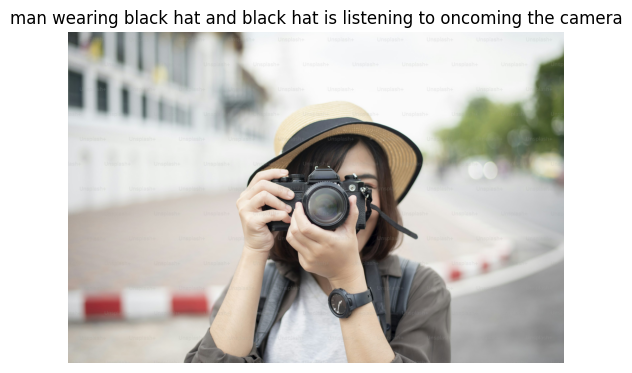

In [58]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Load the pre-trained VGG16 model if not loaded
base_model = VGG16(weights='imagenet')
model_vgg = Model(inputs=base_model.inputs, outputs=base_model.get_layer('fc2').output)

# Function to extract features
def extract_features_vgg(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_vgg.predict(x, verbose=0)
    return features.reshape((1, 4096))

# Function to clean prediction
def clean_caption(raw_caption):
    words = raw_caption.split()
    cleaned = [w for w in words if w not in ('startseq', 'endseq')]
    return ' '.join(cleaned)

# Path to new uploaded image
img_path = "premium_photo-1664474619075-644dd191935f.jpg"

# Extract features and predict caption
feature = extract_features_vgg(img_path)
raw_caption = predict_caption(model, feature, tokenizer, max_length)
cleaned_caption = clean_caption(raw_caption)

# Display result
print("🖼️ Predicted Caption:")
print(cleaned_caption)

img = PILImage.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(cleaned_caption)
plt.show()


In [67]:
from google.colab import files
uploaded = files.upload()


Saving WhatsApp Image 2025-04-30 at 06.13.55_674883da.jpg to WhatsApp Image 2025-04-30 at 06.13.55_674883da.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_239']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


🖼️ Predicted Caption:
man in red jacket is standing on the sidewalk


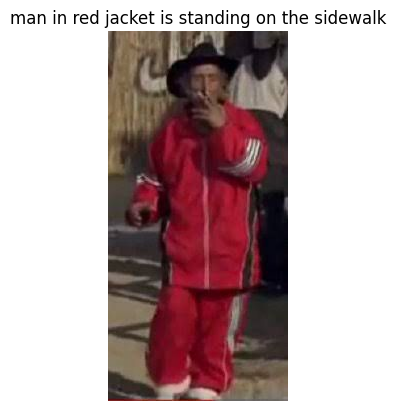

In [68]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Load the pre-trained VGG16 model if not loaded
base_model = VGG16(weights='imagenet')
model_vgg = Model(inputs=base_model.inputs, outputs=base_model.get_layer('fc2').output)

# Function to extract features
def extract_features_vgg(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_vgg.predict(x, verbose=0)
    return features.reshape((1, 4096))

# Function to clean prediction
def clean_caption(raw_caption):
    words = raw_caption.split()
    cleaned = [w for w in words if w not in ('startseq', 'endseq')]
    return ' '.join(cleaned)

# Path to new uploaded image
img_path = "WhatsApp Image 2025-04-30 at 06.13.55_674883da.jpg"

# Extract features and predict caption
feature = extract_features_vgg(img_path)
raw_caption = predict_caption(model, feature, tokenizer, max_length)
cleaned_caption = clean_caption(raw_caption)

# Display result
print("🖼️ Predicted Caption:")
print(cleaned_caption)

img = PILImage.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(cleaned_caption)
plt.show()


In [69]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Image 2025-04-30 at 06.13.36_24a81368.jpg to WhatsApp Image 2025-04-30 at 06.13.36_24a81368.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_285']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


🖼️ Predicted Caption:
baby in blue shirt is sitting on the playground


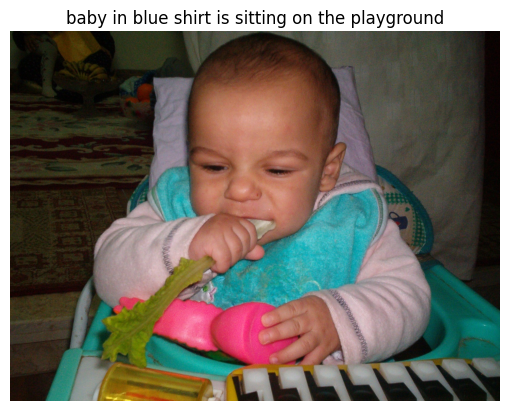

In [71]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Load the pre-trained VGG16 model if not loaded
base_model = VGG16(weights='imagenet')
model_vgg = Model(inputs=base_model.inputs, outputs=base_model.get_layer('fc2').output)

# Function to extract features
def extract_features_vgg(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_vgg.predict(x, verbose=0)
    return features.reshape((1, 4096))

# Function to clean prediction
def clean_caption(raw_caption):
    words = raw_caption.split()
    cleaned = [w for w in words if w not in ('startseq', 'endseq')]
    return ' '.join(cleaned)

# Path to new uploaded image
img_path = "WhatsApp Image 2025-04-30 at 06.13.36_24a81368.jpg"

# Extract features and predict caption
feature = extract_features_vgg(img_path)
raw_caption = predict_caption(model, feature, tokenizer, max_length)
cleaned_caption = clean_caption(raw_caption)

# Display result
print("🖼️ Predicted Caption:")
print(cleaned_caption)

img = PILImage.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(cleaned_caption)
plt.show()


In [63]:
from google.colab import files
uploaded = files.upload()


Saving images (1).jpg to images (1).jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_216']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


🖼️ Predicted Caption:
man in blue and white jacket is riding his bike on his bike


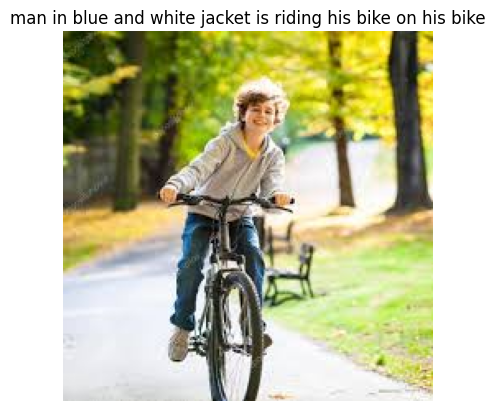

In [66]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# Load the pre-trained VGG16 model if not loaded
base_model = VGG16(weights='imagenet')
model_vgg = Model(inputs=base_model.inputs, outputs=base_model.get_layer('fc2').output)

# Function to extract features
def extract_features_vgg(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_vgg.predict(x, verbose=0)
    return features.reshape((1, 4096))

# Function to clean prediction
def clean_caption(raw_caption):
    words = raw_caption.split()
    cleaned = [w for w in words if w not in ('startseq', 'endseq')]
    return ' '.join(cleaned)

# Path to new uploaded image
img_path = "images (1).jpg"

# Extract features and predict caption
feature = extract_features_vgg(img_path)
raw_caption = predict_caption(model, feature, tokenizer, max_length)
cleaned_caption = clean_caption(raw_caption)

# Display result
print("🖼️ Predicted Caption:")
print(cleaned_caption)

img = PILImage.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(cleaned_caption)
plt.show()
